_This notebook contains code and comments from Section 7.2 of the book [Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning). Please see the book for additional details on this topic. This notebook and code are released under the [MIT license](https://github.com/gkunapuli/ensemble-methods-notebooks/blob/master/LICENSE)._

## 7.2	Parallel Ensembles for Regression

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### 7.2.1 Random Forests & ExtraTrees for Regression
In this section, we look at two classical parallel ensemble methods for regression: Random Forests and ExtraTrees. We use the AutoMPG data set, which is a classical benchmark data set for regression.

In [2]:
# # Load the data from the UCI repository, clean it and save it as a CSV file
# url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
# column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
#                 'Acceleration', 'Model Year', 'Origin']

# data = pd.read_csv(url, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)
# data = data.dropna()
# data.to_csv('./data/ch07/autompg.csv', index=False)

**Listing 7.2**: Loading and pre-processing the AutoMPG data set

In [3]:
# Load the AutoMPG data set from the data folder
data = pd.read_csv('./data/ch07/autompg.csv')
data.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [4]:
# Get indices for the features and labels
labels = data.columns.get_loc('MPG')
features = np.setdiff1d(np.arange(0, len(data.columns), 1), labels)

# Split into train and test sets
from sklearn.model_selection import train_test_split
trn, tst = train_test_split(data, test_size=0.2, random_state=42)

# Split into features and labels
from sklearn.preprocessing import StandardScaler
preprocessor = StandardScaler().fit(trn)
trn, tst = preprocessor.transform(trn), preprocessor.transform(tst)
Xtrn, ytrn = trn[:, features], trn[:, labels]
Xtst, ytst = tst[:, features], tst[:, labels]

**Listing 7.3**: Random Forest and ExtraTrees for Regression

In [5]:
# Train several ML models
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

ensembles = {'Random Forest MSE': RandomForestRegressor(criterion='squared_error'),
             'Random Forest MAE': RandomForestRegressor(criterion='absolute_error'),
             'ExtraTrees MSE': ExtraTreesRegressor(criterion='squared_error'),
             'ExtraTrees MAE': ExtraTreesRegressor(criterion='absolute_error')}

results = pd.DataFrame()
ypred_trn = {}
ypred_tst = {}

for method, ensemble in ensembles.items():
    ensemble.fit(Xtrn, ytrn)
    ypred_trn[method] = ensemble.predict(Xtrn)
    ypred_tst[method] = ensemble.predict(Xtst)
    res = {'Package-Method-Loss': method, 
            'Train MSE': mean_squared_error(ytrn, ypred_trn[method]),
            'Train MAE': mean_absolute_error(ytrn, ypred_trn[method]), 
            'Test MSE': mean_squared_error(ytst, ypred_tst[method]),
            'Test MAE': mean_absolute_error(ytst, ypred_tst[method])}
    results = pd.concat([results, pd.DataFrame.from_dict([res])], ignore_index=True)

In [6]:
pd.options.display.float_format = '{:,.4f}'.format
print(results)

  Package-Method-Loss  Train MSE  Train MAE  Test MSE  Test MAE
0   Random Forest MSE     0.0180     0.0940    0.0900    0.2135
1   Random Forest MAE     0.0195     0.0972    0.0930    0.2232
2      ExtraTrees MSE     0.0000     0.0000    0.0785    0.2017
3      ExtraTrees MAE     0.0000     0.0000    0.0721    0.1947


### 7.2.2 Combining Predictions for Regression
The predictions of several regression models (such as those trained above) can be combined / ensembled into a final prediction. Since many of the individual models that we combine here are themselves ensembles, we end up with an _ensemble of ensembles_.

First, we use combining functions such as mean, median, max, min.

**Listing 7.4**: Aggregators for Continuous-Valued Labels

In [7]:
agg_methods = ['Mean', 'Median', 'Max', 'Min']
aggregators = [np.mean, np.median, np.max, np.min]

results = pd.DataFrame()
ypred_trn_values = np.array(list(ypred_trn.values()))
ypred_tst_values = np.array(list(ypred_tst.values()))

for method, aggregate in zip(agg_methods, aggregators):
    yagg_trn = aggregate(ypred_trn_values, axis=0)
    yagg_tst = aggregate(ypred_tst_values, axis=0)
    
    res = {'Aggregator': method, 
            'Train MSE': mean_squared_error(ytrn, yagg_trn),
            'Train MAE': mean_absolute_error(ytrn, yagg_trn), 
            'Test MSE': mean_squared_error(ytst, yagg_tst),
            'Test MAE': mean_absolute_error(ytst, yagg_tst)}
    results = pd.concat([results, pd.DataFrame.from_dict([res])], ignore_index=True)

In [8]:
print(results)

  Aggregator  Train MSE  Train MAE  Test MSE  Test MAE
0       Mean     0.0046     0.0473    0.0799    0.2060
1     Median     0.0036     0.0399    0.0796    0.2050
2        Max     0.0098     0.0571    0.0957    0.2216
3        Min     0.0134     0.0543    0.0763    0.1994


Next, we can stack these predictions with a second-level learner (or meta-learner). We'll use an artificial neural network as a meta learner here.

**Listing 7.5**: Stacking regression models

In [9]:
from sklearn.ensemble import StackingRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor


estimators = [('Kernel Ridge Regression', KernelRidge(kernel='rbf', gamma=0.1)), 
              ('Support Vector Machine', SVR(kernel='rbf', gamma=0.1)),
              ('K-Nearest Neighbors', KNeighborsRegressor(n_neighbors=3)),
              ('ExtraTrees', ExtraTreesRegressor(n_estimators=50, criterion='absolute_error'))]

meta_learner = MLPRegressor(hidden_layer_sizes=(50, 50, 50), max_iter=1000)

stack = StackingRegressor(estimators, final_estimator=meta_learner, cv=3)
stack.fit(Xtrn, ytrn);

In [10]:
ypred_trn = stack.predict(Xtrn)
ypred_tst = stack.predict(Xtst)

print('Train MSE = {0:5.4f}, Train MAE = {1:5.4f}\n' \
      'Test MSE = {2:5.4f}, Test MAE = {3:5.4f}'.format(
      mean_squared_error(ytrn, ypred_trn),
      mean_absolute_error(ytrn, ypred_trn),
      mean_squared_error(ytst, ypred_tst),
      mean_absolute_error(ytst, ypred_tst)))

Train MSE = 0.0479, Train MAE = 0.1519
Test MSE = 0.0891, Test MAE = 0.2229


---
## 7.3 Sequential Ensembles for Regression

In regression problems, residuals convey two important pieces of information to the base learners. The magnitude of the residual of each training example indicates the extent of the error in fitting, while the sign of the residual indicates whether the model is under or overestimating.

The loss function and, more importantly, its derivatives allow us to measure the residual between the current model’s prediction and the true label. By changing the loss function, we are essentially changing how we prioritize different examples.

Both gradient boosting and Newton boosting use shallow regression trees as weak base learners to fit residuals and approximate the gradient of the loss function.

### 7.3.1 Loss Functions for Regression

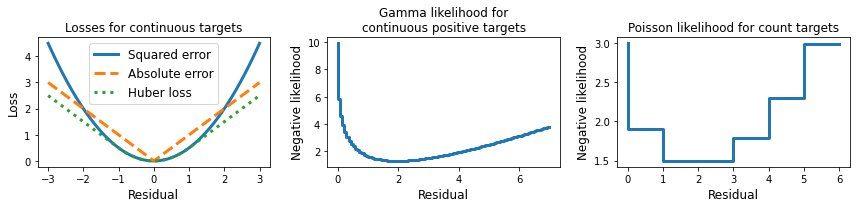

In [11]:
import scipy
from scipy.stats import poisson, gamma

def mse(x):
    return 0.5 * x**2

def huber(x):
    return scipy.special.huber(1., x)
    

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))

xx = np.linspace(-3., 3., num=100)
losses = [mse, np.abs, huber]
styles = ['-', '--', ':']

for style, loss in zip(styles, losses):
    ax[0].plot(xx, loss(xx), linestyle=style, linewidth=3)
ax[0].set_xlabel('Residual', fontsize=12)
ax[0].set_ylabel('Loss', fontsize=12)
ax[0].set_title('Losses for continuous targets', fontsize=12)
ax[0].legend(['Squared error', 'Absolute error', 'Huber loss'], fontsize=12)


xx = np.linspace(0.01, 7., num=100)
dist = gamma(a=3, loc=0., scale=1)
yy = -np.log(dist.pdf(xx))
ax[1].step(xx, yy, linewidth=3)
ax[1].set_xlabel('Residual', fontsize=12)
ax[1].set_ylabel('Negative likelihood', fontsize=12)
ax[1].set_title('Gamma likelihood for\ncontinuous positive targets', fontsize=12)

xx = np.arange(0, 7)
dist = poisson(3)
yy = -np.log(dist.pmf(xx))
ax[2].step(xx, yy, linewidth=3)
ax[2].set_xlabel('Residual', fontsize=12)
ax[2].set_ylabel('Negative likelihood', fontsize=12)
ax[2].set_title('Poisson likelihood for count targets', fontsize=12)

fig.tight_layout()
plt.savefig('./figures/CH07_F10_Kunapuli.png', format='png', dpi=300, bbox_inches='tight')
plt.savefig('./figures/CH07_F10_Kunapuli.pdf', format='pdf', dpi=300, bbox_inches='tight')

### 7.3.2 LightGBM and XGBoost for Regression

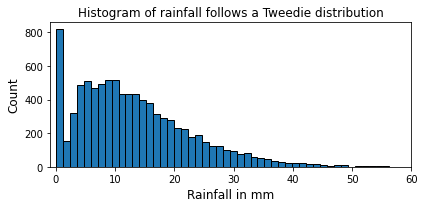

In [12]:
import tweedie

samples = tweedie.tweedie(mu=12, p=1.2, phi=5).rvs(10000)
samples = np.concatenate((samples[samples > 0], np.zeros((800, ))))

fig, ax = plt.subplots(figsize=(6, 3))
plt.hist(samples, bins=60, edgecolor='k')
plt.xlabel('Rainfall in mm', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Histogram of rainfall follows a Tweedie distribution', fontsize=12)
plt.xlim(-1, 60)

fig.tight_layout()
plt.savefig('./figures/CH07_F11_Kunapuli.png', format='png', dpi=300, bbox_inches='tight')
plt.savefig('./figures/CH07_F11_Kunapuli.pdf', format='pdf', dpi=300, bbox_inches='tight')

In [13]:
samples

array([8.0428869 , 2.71342611, 6.07008138, ..., 0.        , 0.        ,
       0.        ])

**Listing 7.6**. Using LightGBM with Huber Loss

In [14]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV

parameters = {'alpha': [0.3, 0.9, 1.8],
              'max_depth': np.arange(2, 5, step=1), 
              'learning_rate': 2**np.arange(-8., 2., step=2),
              'subsample': [0.6, 0.7, 0.8],
              'lambda_l1': [0.01, 0.1, 1],
              'lambda_l2': [0.01, 0.1, 1e-1, 1]}

lgb = LGBMRegressor(objective='huber', n_estimators=10, verbose=-1)
param_tuner = RandomizedSearchCV(lgb, parameters, n_iter=20, cv=5, refit=True, verbose=1, random_state=42)
# param_tuner.fit(Xtrn, ytrn, eval_set=[(Xtst, ytst)], eval_metric='mse', verbose=False)
param_tuner.fit(Xtrn, ytrn, eval_set=[(Xtst, ytst)], eval_metric='mse')

ypred_trn = param_tuner.best_estimator_.predict(Xtrn)
ypred_tst = param_tuner.best_estimator_.predict(Xtst)
print('Train MSE = {0:5.4f}, Train MAE = {1:5.4f}\n' \
      'Test MSE = {2:5.4f}, Test MAE = {3:5.4f}'.format(
      mean_squared_error(ytrn, ypred_trn), mean_absolute_error(ytrn, ypred_trn),
      mean_squared_error(ytst, ypred_tst), mean_absolute_error(ytst, ypred_tst)))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[1]	valid_0's l2: 0.815514	valid_0's huber: 0.178764
[2]	valid_0's l2: 0.814181	valid_0's huber: 0.178549
[3]	valid_0's l2: 0.81285	valid_0's huber: 0.178336
[4]	valid_0's l2: 0.811521	valid_0's huber: 0.178122
[5]	valid_0's l2: 0.810194	valid_0's huber: 0.177908
[6]	valid_0's l2: 0.808869	valid_0's huber: 0.177695
[7]	valid_0's l2: 0.807546	valid_0's huber: 0.177482
[8]	valid_0's l2: 0.806226	valid_0's huber: 0.177269
[9]	valid_0's l2: 0.804908	valid_0's huber: 0.177056
[10]	valid_0's l2: 0.803592	valid_0's huber: 0.176843
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=

[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[1]	valid_0's l2: 0.202313	valid_0's huber: 0.101157
[2]	valid_0's l2: 0.188896	valid_0's huber: 0.0944478
[3]	valid_0's l2: 0.167395	valid_0's huber: 0.0836974
[4]	valid_0's l2: 0.145311	valid_0's huber: 0.0726554
[5]	valid_0's l2: 0.139224	valid_0's huber: 0.0696119
[6]	valid_0's l2: 0.125994	valid_0's huber: 0.0629969
[7]	valid_0's l2: 0.128975	valid_0's huber: 0.0644877
[8]	valid_0's l2: 0.124667	valid_0's huber: 0.0623336
[9]	valid_0's l2: 0.118207	valid_0's huber: 0.0591037
[10]	valid_0's l2: 0.11692	valid_0's huber: 0.05846
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[1]	valid_0's l2: 0.613071	valid_0's huber: 0.274

[9]	valid_0's l2: 0.122317	valid_0's huber: 0.0611584
[10]	valid_0's l2: 0.113309	valid_0's huber: 0.0566544
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[1]	valid_0's l2: 0.224044	valid_0's huber: 0.112022
[2]	valid_0's l2: 0.215145	valid_0's huber: 0.107572
[3]	valid_0's l2: 0.157253	valid_0's huber: 0.0786265
[4]	valid_0's l2: 0.151101	valid_0's huber: 0.0755506
[5]	valid_0's l2: 0.147234	valid_0's huber: 0.0736171
[6]	valid_0's l2: 0.142182	valid_0's huber: 0.0710909
[7]	valid_0's l2: 0.141629	valid_0's huber: 0.0708143
[8]	valid_0's l2: 0.131829	valid_0's huber: 0.0659145
[9]	valid_0's l2: 0.137248	valid_0's huber: 0.0686241
[10]	valid_0's l2: 0.136528	valid_0's huber: 0.0682638
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=1, reg

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[1]	valid_0's l2: 0.820393	valid_0's huber: 0.179495
[2]	valid_0's l2: 0.819063	valid_0's huber: 0.179283
[3]	valid_0's l2: 0.817735	valid_0's huber: 0.179071
[4]	valid_0's l2: 0.81641	valid_0's huber: 0.17886
[5]	valid_0's l2: 0.815087	valid_0's huber: 0.178649
[6]	valid_0's l2: 0.813766	valid_0's huber: 0.178438
[7]	valid_0's l2: 0.812447	valid_0's huber: 0.178228
[8]	valid_0's l2: 0.811131	valid_0's huber: 0.178017
[9]	valid_0's l2: 0.809816	valid_0's huber: 0.177808
[10]	valid_0's l2: 0.808504	valid_0's huber: 0.177598
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[1]	valid_0's l2: 0.815141	valid_0's huber: 0.178705
[2]	

[1]	valid_0's l2: 0.812908	valid_0's huber: 0.351869
[2]	valid_0's l2: 0.809347	valid_0's huber: 0.350531
[3]	valid_0's l2: 0.805804	valid_0's huber: 0.349198
[4]	valid_0's l2: 0.802277	valid_0's huber: 0.347869
[5]	valid_0's l2: 0.798767	valid_0's huber: 0.346545
[6]	valid_0's l2: 0.795274	valid_0's huber: 0.345226
[7]	valid_0's l2: 0.791797	valid_0's huber: 0.343911
[8]	valid_0's l2: 0.788337	valid_0's huber: 0.342601
[9]	valid_0's l2: 0.784894	valid_0's huber: 0.341296
[10]	valid_0's l2: 0.781467	valid_0's huber: 0.339995
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[1]	valid_0's l2: 0.826144	valid_0's huber: 0.358681
[2]	valid_0's l2: 0.822573	valid_0's huber: 0.357343
[3]	valid_0's l2: 0.819021	valid_0's huber: 0.356011
[4]	valid_0's l2: 0.815487	valid_0's huber: 0.354684
[5]	valid_0's l2: 0.811971	valid_0's huber: 0.353362

[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[1]	valid_0's l2: 0.81662	valid_0's huber: 0.178893
[2]	valid_0's l2: 0.811549	valid_0's huber: 0.178084
[3]	valid_0's l2: 0.80651	valid_0's huber: 0.17728
[4]	valid_0's l2: 0.801505	valid_0's huber: 0.176479
[5]	valid_0's l2: 0.796532	valid_0's huber: 0.175682
[6]	valid_0's l2: 0.791593	valid_0's huber: 0.174889
[7]	valid_0's l2: 0.786661	valid_0's huber: 0.174097
[8]	valid_0's l2: 0.781763	valid_0's huber: 0.173309
[9]	valid_0's l2: 0.776896	valid_0's huber: 0.172524
[10]	valid_0's l2: 0.772063	valid_0's huber: 0.171744
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[1]	valid_0's l2: 0.81143	valid_0's huber: 0.178105
[2]	valid_0's 

[5]	valid_0's l2: 0.711326	valid_0's huber: 0.161938
[6]	valid_0's l2: 0.692204	valid_0's huber: 0.158675
[7]	valid_0's l2: 0.673589	valid_0's huber: 0.155473
[8]	valid_0's l2: 0.65716	valid_0's huber: 0.152816
[9]	valid_0's l2: 0.639535	valid_0's huber: 0.149738
[10]	valid_0's l2: 0.622457	valid_0's huber: 0.146741
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[1]	valid_0's l2: 0.593078	valid_0's huber: 0.267099
[2]	valid_0's l2: 0.42639	valid_0's huber: 0.197221
[3]	valid_0's l2: 0.307745	valid_0's huber: 0.145404
[4]	valid_0's l2: 0.232379	valid_0's huber: 0.111357
[5]	valid_0's l2: 0.182093	valid_0's huber: 0.0880395
[6]	valid_0's l2: 0.157566	valid_0's huber: 0.0762438
[7]	valid_0's l2: 0.137156	valid_0's huber: 0.0666247
[8]	valid_0's l2: 0.126056	valid_0's huber: 0.0615663
[9]	valid_0's l2: 0.116204	valid_0's huber: 0.05

**Listing 7.7**. Using XGBoost with pseudo-Huber Loss

In [15]:
from xgboost import XGBRegressor

parameters = {'max_depth': np.arange(2, 5, step=1), 
              'learning_rate': 2**np.arange(-8., 2., step=2),
              'colsample_bytree': [0.6, 0.7, 0.8],
              'reg_alpha': [0.01, 0.1, 1],
              'reg_lambda': [0.01, 0.1, 1e-1, 1]}

xgb = XGBRegressor(objective='reg:pseudohubererror', eval_metric='rmse')
param_tuner = RandomizedSearchCV(xgb, parameters, n_iter=20, cv=5, refit=True, verbose=1, random_state=42)
param_tuner.fit(Xtrn, ytrn, eval_set=[(Xtst, ytst)], verbose=False)

ypred_trn = param_tuner.best_estimator_.predict(Xtrn)
ypred_tst = param_tuner.best_estimator_.predict(Xtst)
print('Train MSE = {0:5.4f}, Train MAE = {1:5.4f}\n' \
      'Test MSE = {2:5.4f}, Test MAE = {3:5.4f}'.format(
      mean_squared_error(ytrn, ypred_trn), mean_absolute_error(ytrn, ypred_trn),
      mean_squared_error(ytst, ypred_tst), mean_absolute_error(ytst, ypred_tst)))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Train MSE = 0.0451, Train MAE = 0.1572
Test MSE = 0.0947, Test MAE = 0.2244
